In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi'] = 200

## Signature operations

In [2]:
def generate_blue_to_red(N):
    # Create a colormap from red to blue
    cmap = plt.get_cmap('viridis')  # 'RdBu_r' is red to blue reversed
    colors = [mcolors.rgb2hex(cmap(i)[:3]) for i in np.linspace(0, 1, N)]
    return colors

In [3]:
def make_canonical_element(indices: list[int], n: int) -> np.array:
	""" 
		Construct the element of the canonical basis for a tensor of order len(indices), in dimension n. 
		indices are the indices of the canonical element
	"""
	x = np.zeros([n for _ in range(len(indices))])
	x[tuple(indices)] =1
	return x

In [4]:
def shuffle_product_basis(left: list[int], right: list[int], n: int) -> list[np.array]:
	"""
		Perform the shuffle product between two signature basis

		left, right: "word", i.e. any element of the canonical basis of any tensor of any order, with dimension equal to n.
		n: dimension of the tensors
	"""
	
	if len(left) == 0:
		return make_canonical_element(right, n)
	elif len(right) == 0:
		return make_canonical_element(left, n)
	
	(begin_left, last_left) = left[:-1], left[-1]
	(begin_right, last_right) = right[:-1], right[-1]

	sub_left = shuffle_product_basis(begin_left, right, n)
	sub_right = shuffle_product_basis(left, begin_right, n)

	return (
		np.tensordot(sub_left, make_canonical_element([last_left], n), axes=0) +
		np.tensordot(sub_right, make_canonical_element([last_right], n), axes=0)
	)

In [5]:
def decompose_to_basis(tensor: np.ndarray, eps: float = 1e-5):
	decomposition = []
	for index in np.ndindex(tensor.shape):
		if np.abs(tensor[index]) > eps:
			decomposition.append( (tensor[index], index) )
	return decomposition

In [6]:
def shuffle_product(left: np.ndarray, right: np.ndarray) -> list[np.ndarray]:
	if len(left.shape) == 0 and len(right.shape)  == 0:
		return np.array(left * right)
	
	# guess the dimension of the product
	if len(left.shape) == 0:
		dim = right.shape[0]
	else:
		dim = left.shape[0]
		
	# some utility values on the tensors (dimension, trucation of output signature)
	tensor_order = len(left.shape) + len(right.shape)

	# decompose into sum of single letters
	basis_left = decompose_to_basis(left)
	basis_right = decompose_to_basis(right)
	
	# the products will all be a tensor of the same dim and order
	product_tensor = np.zeros( tuple(dim for _ in range(tensor_order)) )
	for (coord_left, index_left) in basis_left:
		for (coord_right, index_right) in basis_right:
			el = coord_left * coord_right * shuffle_product_basis(index_left, index_right, dim)
			product_tensor += el

	return product_tensor

In [7]:
def extract_single_tensor_from_sig(signature: list[np.ndarray], eps: float = 1e-5) -> np.ndarray:
	"""
		given a signature composed from A SINGLE TENSOR, extract this tensor 
		asserts False if the signature is composed of multiple arrays
	"""

	tensor = None
	for t in signature:
		if np.linalg.norm(t) > eps:
			assert tensor == None, "Signature is not composed of a single tensor"
			tensor = t

	return t

In [8]:
def decompose_shuffle_result(shuffle_result: np.array) -> list[tuple[int]]:
	"""
		Given the result of some shuffle product, return the indices of the individual basis element that composes it
	"""
	return list(filter(
		lambda x: abs(shuffle_result[x]) > 1e-6,
		np.ndindex(shuffle_result.shape)
	))

In [9]:
def generate_brownian(t0, t1, n_divs, n_curves):
	return np.cumsum(np.concatenate(
		(np.zeros((n_curves, 1)), np.sqrt( (t1-t0) / n_divs) * npr.normal(0, 1, (n_curves, n_divs)) ),
		axis=1
	), axis=1)

In [10]:
def signature( x: np.ndarray, trunc: int ):
	"""
		Compute the truncated signature of x, where x is a sample of some stochastic process
		trunc is the maximum tensor order of the signature
	"""

	assert trunc >= 0, "trunc is the maximum tensor order, it cannot be negative"

	n_divs, dim = x.shape[1], x.shape[0]
	sig = [np.ones(n_divs), x]

	if trunc <= 2:
		return sig[:trunc+1]

	# Compute the next signature recursively
	for n in range(2, trunc+1):
		# numpy shape corresponding to the nth tensor of the signature
		shape_n = tuple(dim for _ in range(n))
		sig_n = np.zeros( shape=shape_n+(n_divs,) )
		for index in np.ndindex(shape_n):
			integrals = np.zeros(n_divs)
			for i in range(n_divs-1):
				# Compute a stratonovich stochastic integral (taking the average instead of the left value)
				mean_val = (sig[n-1][(index[:-1] + (i,))] + sig[n-1][(index[:-1] + (i+1,))]) / 2
				integrals[i+1] = mean_val * (x[index[-1], i+1] - x[index[-1], i])
			sig_n[index] = integrals.cumsum()
		sig.append(sig_n)
	return sig

In [11]:
def signature_add(sig_left, sig_right):
	added_sigs = []
	for i in range(max(len(sig_left), len(sig_right))):
		if i >= len(sig_left):
			added_sigs.append( sig_right[i] )
		elif i >= len(sig_right):
			added_sigs.append( sig_left[i] )
		else:
			added_sigs.append( sig_left[i] + sig_right[i] )

	added_sigs[0] = np.array(added_sigs[0]) # scalar np.array sums to scalar, we need to convert it back to array
	return added_sigs

In [12]:
def signature_prod(sig_left, sig_right):
	assert len(sig_left) >= 1 and len(sig_right) >= 1
	dim = sig_left[1].size
	sig_prod = [ np.zeros(tuple(dim for _ in range(n))) for n in range(len(sig_left) + len(sig_right)) ]
	for i in range(len(sig_left)):
		for j in range(len(sig_right)):
			sig_prod[i+j] += np.tensordot(sig_left[i], sig_right[j], axes=0)
	return sig_prod

In [13]:
def signature_scalar_prod(signature: list[np.ndarray], scalar: float):
	return [el * scalar for el in signature]

In [14]:
def signature_shuffle(sig_left: list[np.ndarray], sig_right: list[np.ndarray]):
	assert len(sig_left) != 0 and len(sig_right) != 0
	assert len(sig_left) != 1 or len(sig_right) != 1, "Could not deduce dimension for scalar signatures, use regular product"

	if len(sig_left) > 1:
		dim = sig_left[1].shape[0]
	else:
		dim = sig_right[1].shape[0]
	max_order = len(sig_left) + len(sig_right)
	
	shuffle_sig = [ np.zeros( tuple(dim for _ in range(n)) ) for n in range(max_order+1) ]

	for tl in sig_left:
		for tr in sig_right:
			prod = shuffle_product(tl, tr)
			shuffle_sig[len(prod.shape)] += prod

	return shuffle_sig

In [15]:
def bracket(sig_left, sig_right):
	bracket_sum = 0.0
	for i in range(min(len(sig_left), len(sig_right))):
		bracket_sum += (sig_left[i] * sig_right[i]).sum()
	return bracket_sum

In [16]:
def bracket_with_process(cst_sig, process_sig):
	bracket_sum = np.zeros(process_sig[0].shape)
	for i in range(min(len(cst_sig), len(process_sig))):
		for index in np.ndindex(cst_sig[i].shape):
			bracket_sum += cst_sig[i][index] * process_sig[i][index]
	return bracket_sum

## Variables

In [17]:
# Parameters
n = 100
max_sig_order = 6
times = np.arange(start=0, stop=n+1) / n
x0 = 0
brownians = generate_brownian(0, 1, n, 1)
brownian_sig = signature(np.array([times, brownians.flatten()]), max_sig_order)

## Ornstein-Uhlenbeck

In [18]:
def generate_ornstein_uhlenbeck(t0, t1, brownian_noises, x0, kappa, etha, theta):
	(n_curves, n_divs) = brownian_noises.shape
	brownian_diffs = (brownian_noises[:,1:] - brownian_noises[:,:-1])
	process = np.zeros( (n_curves, n_divs) )
	dt = (t1-t0)/(n_divs-1)
	process[:, 0] = x0
	for i in range(1, process.shape[1]):
		process[:, i] = process[:, i-1] + kappa * (theta - process[:, i-1]) * dt + etha*brownian_diffs[:, i-1]

	return process

In [19]:
def compute_ornstein_uhlenbeck_signature(x0, kappa, etha, theta, exp_order=5):
	left = [ np.array(x0), np.array([kappa*theta, etha]) ]
	# compute exp(-kappa 1)
	right = [np.array(1.0)]
	for n in range(1,exp_order):
		right.append( make_canonical_element(tuple(0 for _ in range(n)), 2) * np.power(-kappa, n))
	return signature_prod(left, right)

In [20]:
def compute_ornstein_uhlenbeck_signature_time(t, x0, kappa, etha, theta, exp_order=5):
	assert exp_order >= 2
	# the scalar part of the signature
	scalar_part = [theta + np.exp(-kappa*t)*(x0-theta), np.zeros(2)]
	# left hand side of the decomposition: exp(+kappa 1)
	expon = [np.array(1.0)]
	for n in range(1, exp_order):
		expon.append( make_canonical_element(tuple(0 for _ in range(n)), 2) * np.power(kappa, n))
	# right hand side of the decomposition: etha 2
	rhs = [np.zeros( () ), np.array([0.0, etha*np.exp(-kappa*t)]) ]
	# final product
	return signature_add(scalar_part, signature_prod(expon, rhs))
	

### Naïve approximation

Here, the signature of the process does not depend on time

In [21]:
def generate_naive_ornstein_sig(times, x0, kappa, etha, theta, max_sig_order):
	ornsteins = generate_ornstein_uhlenbeck(times.min(), times.max(), brownians, x0, kappa, etha, theta)
	true_uhlenbeck_sig = compute_ornstein_uhlenbeck_signature(x0, kappa, etha, theta, max_sig_order)
	ornsteins_approx = []
	for sig_order in range(1, max_sig_order+1):
		# compute the ornstein process using the signature volatility model
		true_uhlenbeck_process_sig = bracket_with_process(true_uhlenbeck_sig[:sig_order+1], brownian_sig)
		ornsteins_approx.append(true_uhlenbeck_process_sig)

	return (ornsteins, ornsteins_approx)

### More stable approximation

This time, the signature depends on the time, and is computed such that the shuffle exponential has a positive coefficient, making it more stable

In [22]:
def generate_stable_ornstein_sig(times, x0, kappa, etha, theta, max_sig_order):
	ornsteins = generate_ornstein_uhlenbeck(times.min(), times.max(), brownians, x0, kappa, etha, theta)
	ornstein_approx = []
	uhlenbeck_sig_time = []
	for t in times:
		uhlenbeck_sig_time.append(
			compute_ornstein_uhlenbeck_signature_time(t, x0, kappa, etha, theta, max_sig_order)
		)

	for sig_order in range(1, max_sig_order+1):
		# compute the ornstein process using the signature volatility model
		uhlenbeck_process_approx = np.zeros(times.shape[0])
		for i in range(times.shape[0]):
			brownian_sig_time = [b[..., i] for b in brownian_sig]
			uhlenbeck_process_approx[i] = bracket(uhlenbeck_sig_time[i][:sig_order+1], brownian_sig_time)
		ornstein_approx.append(uhlenbeck_process_approx)

	return (ornsteins, ornstein_approx)

### Plotting

In [23]:
# Parameters
n = 100
max_sig_order = 7
times = np.arange(start=0, stop=n+1) / n
brownians = generate_brownian(0, 1, n, 1)
brownian_sig = signature(np.array([times, brownians.flatten()]), max_sig_order)

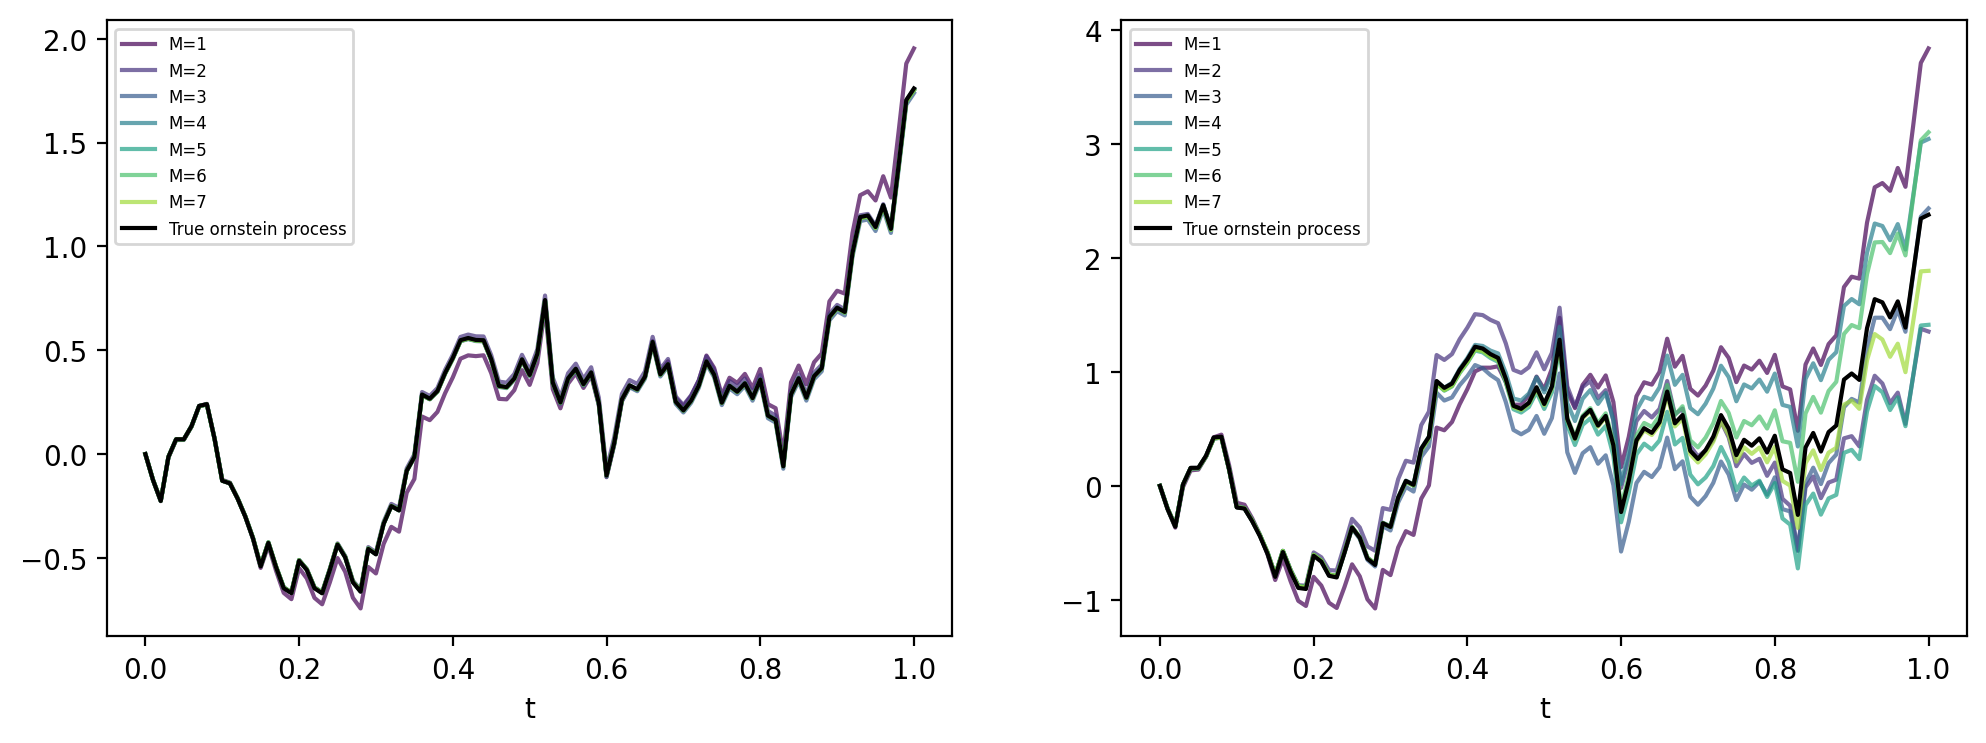

In [24]:
(ornsteins_1, ornsteins_approx_1) = generate_naive_ornstein_sig(times, x0, kappa=1, etha=1.2, theta=0.25, max_sig_order=max_sig_order)
(ornsteins_2, ornsteins_approx_2) = generate_naive_ornstein_sig(times, x0, kappa=4, etha=2.0, theta=0.25, max_sig_order=max_sig_order)
cols = generate_blue_to_red(len(ornsteins_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(ornsteins_approx_1)):
	ax1.plot(times, ornsteins_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(times, ornsteins_1.transpose(), label="True ornstein process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(ornsteins_approx_2)):
	ax2.plot(times, ornsteins_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(times, ornsteins_2.transpose(), label="True ornstein process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

fig.savefig("outputs/ornstein_approx_naive.png")

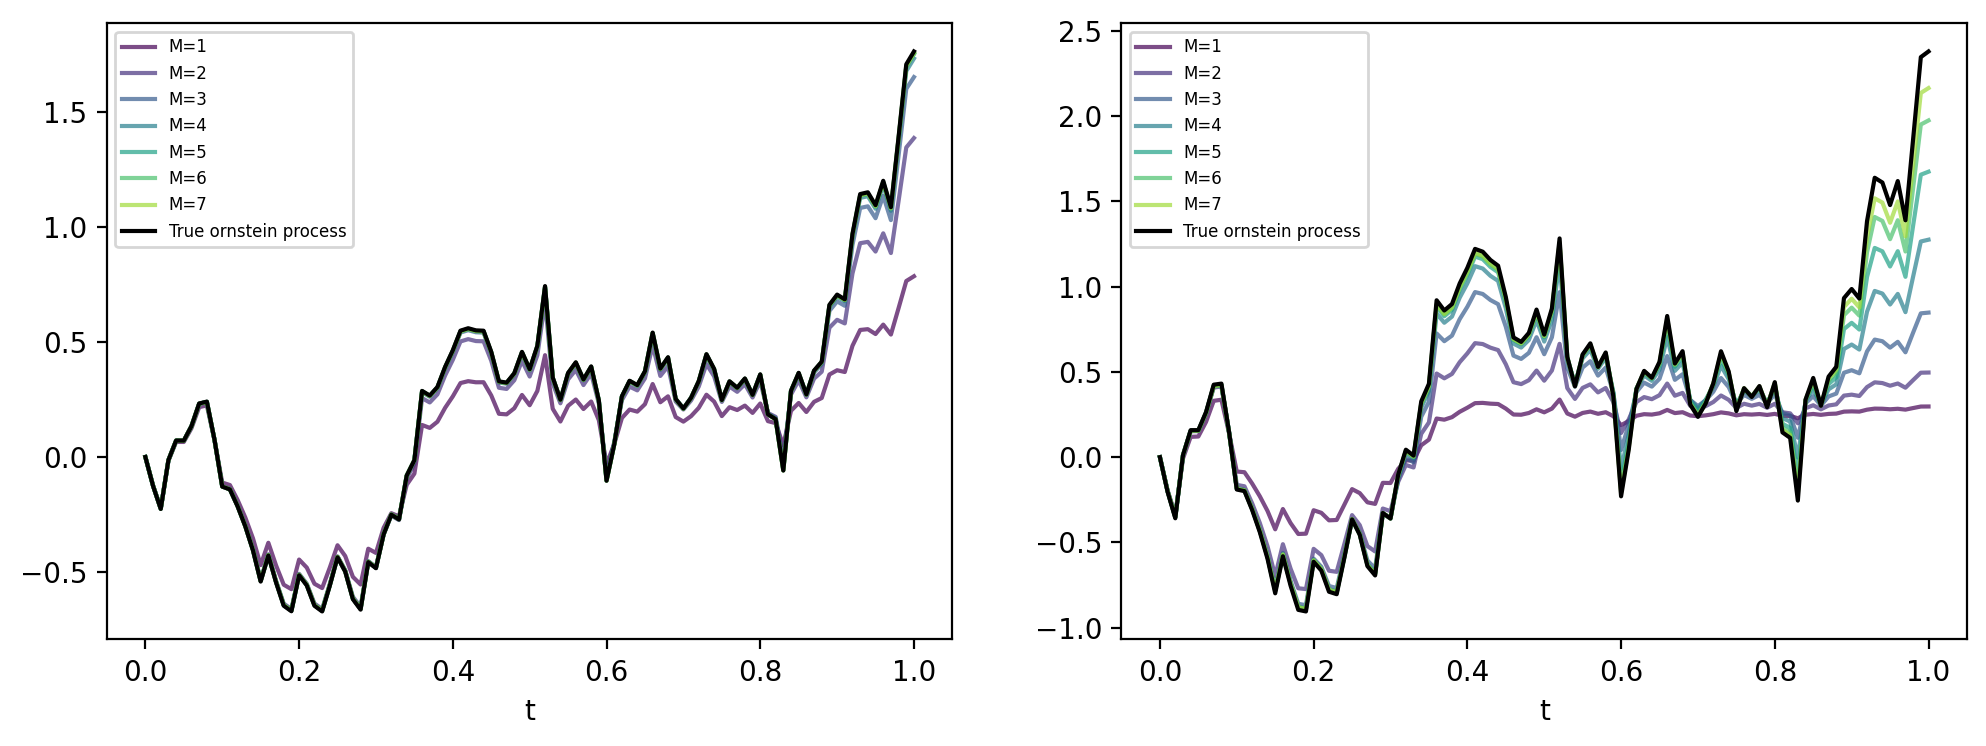

In [25]:
(ornsteins_1, ornstein_approx_1) = generate_stable_ornstein_sig(times, x0, kappa=1, etha=1.2, theta=0.25, max_sig_order=max_sig_order)
(ornsteins_2, ornstein_approx_2) = generate_stable_ornstein_sig(times, x0, kappa=4, etha=2, theta=0.25, max_sig_order=max_sig_order)

ols = generate_blue_to_red(len(ornstein_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(ornstein_approx_1)):
	ax1.plot(times, ornstein_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(times, ornsteins_1.transpose(), label="True ornstein process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(ornstein_approx_2)):
	ax2.plot(times, ornstein_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(times, ornsteins_2.transpose(), label="True ornstein process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

plt.savefig("outputs/ornstein_approx_stable.png")

## Mean-reverting geometric Brownian motion


In [26]:
def generate_mrgbm(t0, t1, brownian_noises, x0, kappa, etha, theta, alpha):
	(n_curves, n_divs) = brownian_noises.shape
	brownian_diffs = (brownian_noises[:,1:] - brownian_noises[:,:-1])
	process = np.zeros( (n_curves, n_divs) )
	dt = (t1-t0)/(n_divs-1)
	process[:, 0] = x0
	for i in range(1, process.shape[1]):
		process[:, i] = process[:, i-1] + kappa * (theta - process[:, i-1]) * dt + (etha + alpha * process[:, i-1])*brownian_diffs[:, i-1]

	return process

In [27]:
def compute_mrgbm_signature(x0, kappa, etha, theta, alpha, exp_order=5):
	assert exp_order >= 2
	# left hand side ...
	lhs = [np.array(x0), np.array([kappa*theta - (alpha*etha)/2, etha])]

	exponent = np.array([-(kappa + (alpha**2)/2), alpha])
	rhs = [ np.array(1.0), exponent]

	# compute the appoximation of exp( -exponent )
	curr_num = exponent
	curr_den = 1
	for n in range(2, exp_order+1):
		curr_num = shuffle_product(exponent, curr_num)
		curr_num_sig = [ np.zeros( tuple(2 for _ in range(i)) ) for i in range(len(curr_num.shape)+1) ]
		curr_den *= n
		
		curr_num_sig[len(curr_num.shape)] = curr_num / curr_den
		rhs = signature_add(rhs, curr_num_sig)

	return signature_prod(lhs, rhs)	

### Naïve approximation

In [28]:
def generate_naive_mrgbm_sig(times, x0, kappa, etha, theta, alpha, max_sig_order):
	mrgbms = generate_mrgbm(times.min(), times.max(), brownians, x0, kappa, etha, theta, alpha)
	true_mrgbm_sig = compute_mrgbm_signature(x0, kappa, etha, theta, alpha, max_sig_order)

	mrgbm_approx = []
	for sig_order in range(1, max_sig_order+1):
		# compute the mrgbm process using the signature volatility model
		true_mrgbm_process_sig = bracket_with_process(true_mrgbm_sig[:sig_order+1], brownian_sig)
		mrgbm_approx.append(true_mrgbm_process_sig)

	return (mrgbms, mrgbm_approx)

### Stable approximation

In [29]:
def compute_mrgbm_signature_times(t_values, x0, kappa, etha, theta, alpha, lamb, exp_order=5):
	lhs = compute_mrgbm_signature(x0, kappa, etha, theta, alpha, exp_order)
	lhs[0] -= theta
	# compute exp(lamb 1)
	rhs = [np.array(1.0)]
	for n in range(1,exp_order):
		rhs.append( make_canonical_element(tuple(0 for _ in range(n)), 2) * np.power(lamb, n))
	
	prod = signature_shuffle(lhs, rhs)

	values = []
	for t in t_values:
		rest = signature_scalar_prod(prod, np.exp(-lamb*t))
		rest[0] += theta
		values.append(rest)

	return values

In [30]:
def generate_stable_mrgbm_sig(times, x0, kappa, etha, theta, alpha, max_sig_order):
	lamb = kappa + (alpha**2)/2
	mrgbms = generate_mrgbm(times.min(), times.max(), brownians, x0, kappa, etha, theta, alpha)
	mrgbms_approx = []
	mrgbm_sig_time = compute_mrgbm_signature_times(times, x0, kappa, etha, theta, alpha, lamb, max_sig_order)

	for sig_order in range(1, max_sig_order+1):
		# compute the ornstein process using the signature volatility model
		mrgbm_process_approx = np.zeros(times.shape[0])
		for i in range(times.shape[0]):
			brownian_sig_time = [b[..., i] for b in brownian_sig]
			mrgbm_process_approx[i] = bracket(mrgbm_sig_time[i][:sig_order+1], brownian_sig_time)
		mrgbms_approx.append(mrgbm_process_approx)

	return (mrgbms, mrgbms_approx)

### Plotting

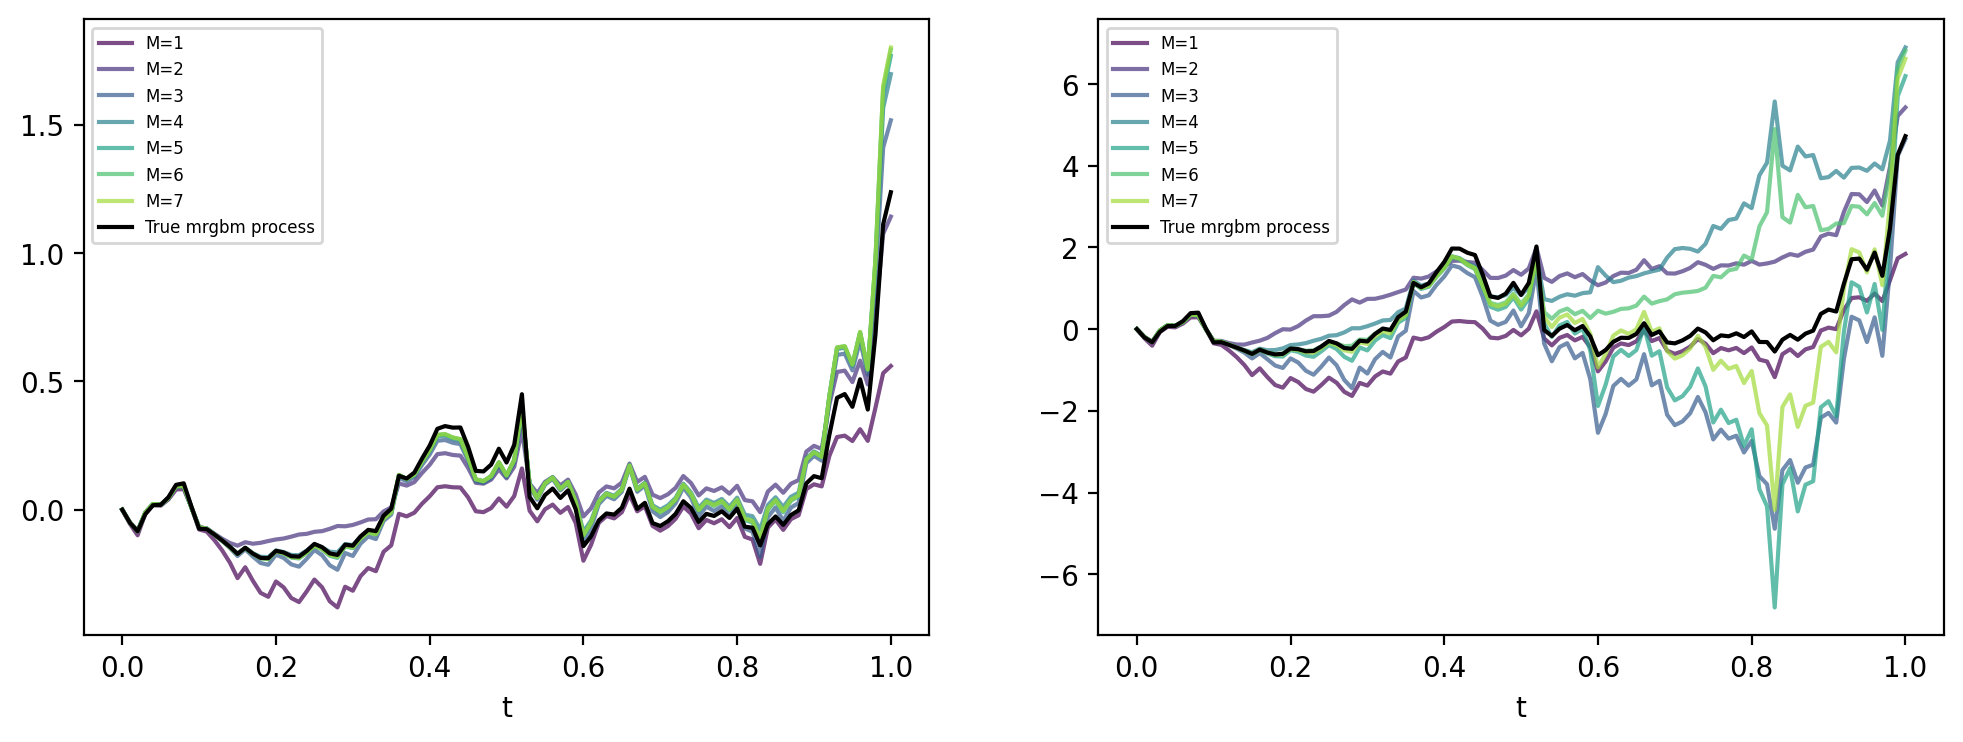

In [31]:
(mrgbms_1, mrgbm_approx_1) = generate_naive_mrgbm_sig(times, x0, kappa=1, etha=0.5, theta=0.25, alpha=1.6, max_sig_order=max_sig_order)
(mrgbms_2, mrgbm_approx_2) = generate_naive_mrgbm_sig(times, x0, kappa=4, etha=2, theta=0.25, alpha=2, max_sig_order=max_sig_order)

ols = generate_blue_to_red(len(mrgbm_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(mrgbm_approx_1)):
	ax1.plot(times, mrgbm_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(times, mrgbms_1.transpose(), label="True mrgbm process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(mrgbm_approx_2)):
	ax2.plot(times, mrgbm_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(times, mrgbms_2.transpose(), label="True mrgbm process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

plt.savefig("outputs/mrgbm_approx_naive.png")

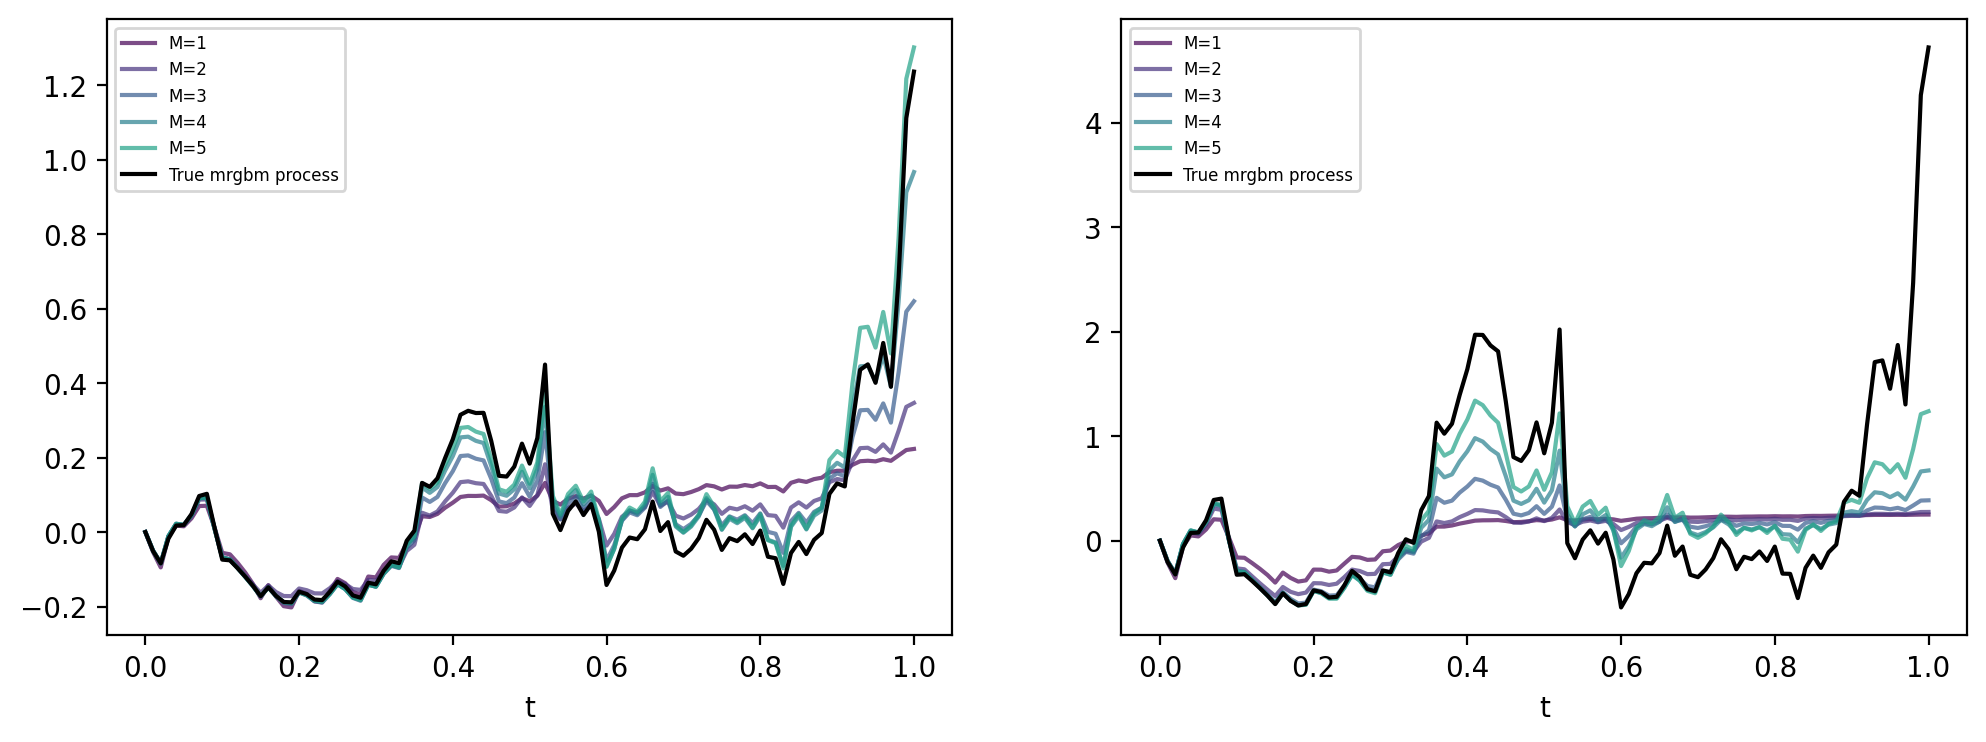

In [32]:
(mrgbms_1, mrgbm_approx_1) = generate_stable_mrgbm_sig(times, x0, kappa=1, etha=0.5, theta=0.25, alpha=1.6, max_sig_order=5)
(mrgbms_2, mrgbm_approx_2) = generate_stable_mrgbm_sig(times, x0, kappa=4, etha=2, theta=0.25, alpha=2, max_sig_order=5)

ols = generate_blue_to_red(len(mrgbm_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(mrgbm_approx_1)):
	ax1.plot(times, mrgbm_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(times, mrgbms_1.transpose(), label="True mrgbm process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(mrgbm_approx_2)):
	ax2.plot(times, mrgbm_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(times, mrgbms_2.transpose(), label="True mrgbm process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

plt.savefig("outputs/mrgbm_approx_stable.png")